## Totally Asymmetric Simple Exclusion Process (TASEP)

This notebook demonstrates Monte Carlo simulations of the totally asymmetric simple exclusion process (TASEP), a simple but paradigmatic model of non-equilibrium dynamics that was introduced by Derrida and coworkers [Derrida, Domany, and Mukamel, J. Stat. Phys. **69**, 667 (1992)].

The TASEP is a stochastic process on a discrete 1D finite lattice. On each of the $L$ sites of the lattice, at most one particle can reside. In each step, a particle at position $x$ moves with probability $1$ to the right, i.e., to $x+1$ *if* that site is empty; otherwise it stays put. At the boundaries, injection and extraction of particles are defined in order to reach non-trivial stationary states of the process: at the first site (left boundary), a particle is injected with probability $\alpha$ if that site was empty. At the last site (right boundary), a particle is extracted with probability $\beta$.

In the result, the process has the two boundary rates $(\alpha,\beta)$ as its sole parameters, at any fixed lattice length $L$. It turns out that the TASEP can be analytically solved, and the mean-field approximation is rather easily discussed, in particular in the continuum limit (see stochastic processes lecture).

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from mpl_toolkits.mplot3d import Axes3D

For our purposes, we define a function to perform a single Monte Carlo step. If takes a state of the TASEP as input, together with the two parameters, and returns the updated state.

As with all multi-particle stochastic-process simulations, in principle two different approaches are conceivable here: either we try to update all particles on the lattice at once, or we take an individual MC step to mean an update for a single, randomly selected particle. The latter (asynchronous) update rule is usually the one to be preferred. It is also, for the TASEP, easier to understand.

Thus, we select a site at random, and if there is a particle and no particle on the site to the right, we move that particle to the right. If our randomly picked site was the first site, and that is empty, we try to inject a particle with the given probability. If the randomly picked site was the last site, we try to remove any particle that might be there. (It turns out that the implementation of what happens at the boundaries is crucial, as the whole phase diagram of the TASEP depends crucially on the boundary conditions. It has to be done as coded here. Change a few if statements in innocently looking ways, and you get nonsense.)

In [2]:
def step (state,alpha,beta):
    L = len(state)
    x = np.random.choice(L)
    if x==0:
        if state[x]==0 and np.random.random()<alpha:
            state[x]=1
        elif state[x]==1 and state[x+1]==0:
            state[x]=0
            state[x+1]=1
    elif x==L-1:
        if np.random.random()<beta:
            state[L-1]=0
    else:
        if state[x]==1 and state[x+1]==0:
            state[x]=0
            state[x+1]=1
    return (state)

The Monte Carlo run is coded next: Given a lattice of size $L$, we start from the initially empty lattice and perform $N_\text{max}$ MC steps as coded above. Of those, $N_\text{init}$ are used to allow the empty lattice to come into a state that is hopefully representative of the stationary state in which we would like to calculate averages. As the simplest average, we then calculate the average occupation number of each site, i.e., the spatial density profile $\rho(x)$.

In [4]:
def run (L, alpha, beta, Nmax, Ninit):
    state = np.zeros(L,dtype="int")
    n = 0
    rho = np.zeros(L)
    rhocnt = 0
    while n < Nmax:
        state = step (state,alpha,beta)
        if n > Ninit:
            rho = rho + state
            rhocnt += 1
        n += 1
    return (rho/rhocnt)

For $\alpha=\beta=1$, the exact solution of the TASEP on the finite lattice is [Derrida, Domany, and Mukamel (1992)] $$ \rho(x_k)=\frac12+\frac{(2k)!\,(L!)^2\,(2L-2k+2)!\,(L-2k+1)}{4(k!)^2\,(2L+1)!\,((L-k+1)!)^2}\,.$$ We code this here, to have a cross-check. The readability of the code is only slightly hampered by the fact that the factorials are only defined for integers but quickly become too big for finite-precision computer-integer arithmetic. We use $k!=\Gamma(k+1)$ with the Euler Gamma function, and the fact that $\ln\Gamma(x)$ is directly implemented in the standard math library of the computer.

In [24]:
def exact11 (L):
    rho = np.zeros(L)
    lLfac = scipy.special.gammaln(L+1)
    for x in range(L):
        k = x+1
        lkfac = scipy.special.gammaln(k+1)
        lk2fac = scipy.special.gammaln(2*k+1)
        llkfac = scipy.special.gammaln(L-k+1+1)
        lrho = lk2fac+lLfac+lLfac+scipy.special.gammaln(2*L-2*k+2+1)+np.log(np.abs(L-2*k+1))
        lrho = lrho - (np.log(4)+lkfac+lkfac+scipy.special.gammaln(2*L+1+1)+llkfac+llkfac)
        rho[x] = 0.5 + np.exp(lrho)*np.sign(L-2*k+1)
    return (rho)

### Test Run

Here is a test case, $\alpha=\beta=1$, for a lattice of length $L=100$. We compare the averaged $\rho(x)$ from our MC simulation with the exact result.

Note that the MC scheme needs quite a number of steps to achieve stationarity. The number of steps needed certainly increases with the lattice site, since in principle that particle number can scale as $L$, and we need then the number of single-particle MC updates also to scale with $L$. On top of that, let's take at least 1000 $L$-fold MC steps to come to stationarity, and then take the remainder of overall 20000 $L$-fold MC steps to average.

In [9]:
L = 100
Nmax = 20000*L
Ninit = 1000*L

In [82]:
alpha1=1
beta1=1
rho1 = run (L, alpha1, beta1, Nmax, Ninit)

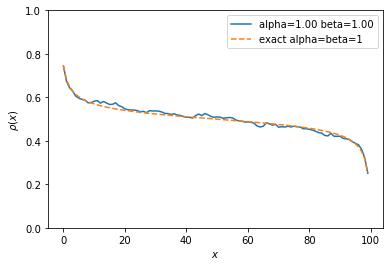

In [83]:
plt.figure()
plt.plot (range(L),rho1,label='alpha={:.2f} beta={:.2f}'.format(alpha1,beta1))
plt.plot (range(L),exact11(L),ls='dashed',label='exact alpha=beta=1')
plt.ylim((0,1))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho(x)$')
plt.legend()
plt.show()

### Phase Diagram of the TASEP

The following command takes **a lot** of time. We essentially repeat the exercise above, but for all values of $(\alpha,\beta)\in[0,1]\times[0,1]$, with some discrete stepping ($\Delta\alpha=\Delta\beta=0.1$ chosen here). Instead of plotting all the density profiles, we try to extract a single average number characterizing the density in the bulk: we try just taking the single value somewhere in the middle of the lattice, and averaging over the central slab of the lattice (of width $L/2$). It turns out that with sufficient averaging, there's not much visible difference, so we just discuss the center-slab averaging.

In [85]:
dalpha = 0.05
abrange = np.arange(dalpha/2,1,dalpha)
diagram = np.zeros((len(abrange),len(abrange)))
mid = np.zeros((len(abrange),len(abrange)))
for i,alpha in enumerate(abrange):
    for j,beta in enumerate(abrange):
        rho = run(L,alpha,beta,Nmax,Ninit)
        mid[i,j] = rho[int(L/2)]
        diagram[i,j] = np.average(rho[int(L/4):int(3*L/4)])

The expected phase diagram is the one from the mean-field theory of the TASEP: there is a region of $\beta\ge\alpha$ and $\alpha\le1/2$, the *low-density (LD) phase* where the bulk is dominated by rapid extraction of particles at the end, keeping the density low; there is for $\alpha\ge\beta$ and $\beta\le1/2$ a *high-density (HD) phase* where particles are more rapidly inserted than extracted, keeping the density high; and for $\alpha\ge1/2$ and $\beta\ge1/2$, the density settles to $\rho=1/2$ and represents the *maximum current (MC)* phase.

We add the expected phase boundaries from the mean-field result as black lines here. Note that the diagonal line $\alpha=\beta\le1/2$ is a first-order transition where the density jumps. We would need a much better grid resolution (costing even more computing time) to see this more properly.

The plot below is a 3D rendition of the same thing. One nicely sees how the phases are distinguished: imagine a sheet at $\rho=1/2$ that is cut along the diagonal $\alpha=\beta\le1/2$. Intuitively, we have to attach the part of the sheet that corresponds to no injection of particles ($\alpha\to0$) to density zero, no matter what is the extraction rate, i.e., along the whole $\beta$-axis. Likewise, if we never extract particles ($\beta\to0$), the density has to approach unity no matter what is the injection rate, so the second part of our cut sheet needs to be attached to density one along the $\alpha$-axis.

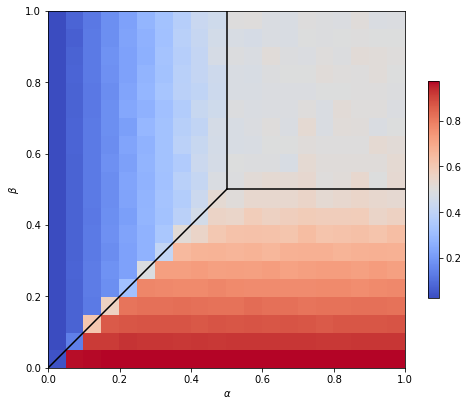

In [113]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.set_aspect(1)
xm,ym = np.meshgrid(np.arange(0,1+dalpha/2,dalpha),np.arange(0,1+dalpha/2,dalpha))
plt.pcolormesh(xm,ym,diagram.T,cmap=plt.cm.coolwarm)
plt.plot(np.arange(0,0.51,0.1),np.arange(0,0.51,0.1),c='black')
plt.plot(np.arange(0.5,1.01,0.1),np.ones(len(np.arange(0.5,1.01,0.1)))*0.5,c='black')
plt.plot(np.ones(len(np.arange(0.5,1.01,0.1)))*0.5,np.arange(0.5,1.01,0.1),c='black')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.colorbar(shrink=0.5)
plt.show()

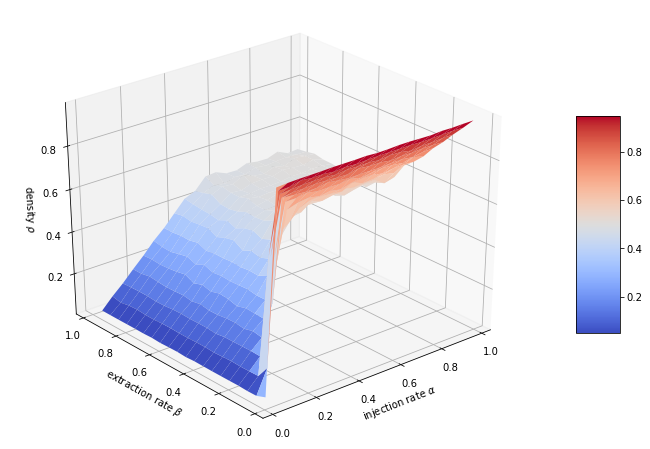

In [123]:
fig3d=plt.figure(figsize=(12,8))
ax3d = fig3d.add_subplot(111,projection='3d')
x3d,y3d = np.meshgrid(abrange,abrange)
surf3d = ax3d.plot_surface(x3d,y3d,diagram.T,cmap=plt.cm.coolwarm)
ax3d.view_init(elev=30.,azim=230.)
fig3d.colorbar(surf3d,shrink=0.5,aspect=5)
ax3d.set_xlabel(r'injection rate $\alpha$')
ax3d.set_ylabel(r'extraction rate $\beta$')
ax3d.set_zlabel(r'density $\rho$')
plt.show()

(Note: of course, in the above 3D plot, the rendering of the branch cut is terrible. It would require some more python magic to fix this. Also note that along the line $\alpha=1-\beta$, from the 3D plot one easily verifies $\rho=\alpha$ there, across the phases. This is a peculiar case already pointed out by Derrida *et al.*)

The current, $j=\rho(1-\rho)$, is in fact continuous. Here is a (feeble) attempt at plotting cross-sections of fixed $\alpha$.

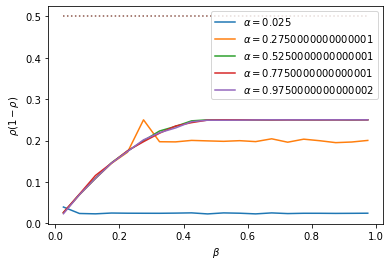

In [112]:
plt.figure()
abl=len(abrange)
for ai in [0,int(abl/4),int(abl/2),int(3*abl/4),-1]:
    plt.plot(abrange,diagram[ai,:]*(1-diagram[ai,:]),label='$\\alpha={}$'.format(abrange[ai]))
plt.plot(abrange,np.ones(abl)*0.5,ls='dotted')
plt.xlabel('$\\beta$')
plt.ylabel('$\\rho(1-\\rho)$')
plt.legend()
plt.show()